# 0 Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import timm
import nltk
nltk.download('punkt_tab')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


[nltk_data] Downloading package punkt_tab to /home/white/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1 Dataset

In [3]:
captions_train_file = '../data/train/captions_train.txt'
captions_val_file = '../data/val/captions_val.txt'
captions_test_file = '../data/test/captions_test.txt'

captions_train_df = pd.read_table(captions_train_file, delimiter=',', header=None, names=['image', 'caption'])
captions_val_df = pd.read_table(captions_val_file, delimiter=',', header=None, names=['image', 'caption'])
captions_test_df = pd.read_table(captions_test_file, delimiter=',', header=None, names=['image', 'caption'])
captions_test_df.dropna(inplace=True)

print(f"Numero di captions nel set di addestramento: {len(captions_train_df)}")
print(f"Numero di captions nel set di validazione: {len(captions_val_df)}")
print(f"Numero di captions nel set di test: {len(captions_test_df)}")

Numero di captions nel set di addestramento: 111240
Numero di captions nel set di validazione: 23835
Numero di captions nel set di test: 23839


## 1.2 Vocabulary class

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_freq = {}
        self.idx = 4
        # self.translator = str.maketrans("","", string.punctuation + string.digits + "\t\r\n")
         

    def __len__(self):
        return len(self.word2idx)

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text)

    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                if word not in self.word_freq:
                    self.word_freq[word] = 1
                else:
                    self.word_freq[word] += 1

                if self.word_freq[word] == self.freq_threshold:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in tokenized_text]

In [4]:
vocab = Vocabulary(freq_threshold=5)
caption_list = captions_train_df['caption'].tolist()
vocab.build_vocabulary(caption_list)

print(f"Dimensione del vocabolario: {len(vocab)}")

Dimensione del vocabolario: 6959


## 1.3 Glove (200)

In [7]:
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Caricati {len(embeddings)} vettori di embedding da GloVe.")
    return embeddings

# Caricamento degli embeddings GloVe
glove_file = '../glove/glove.6B.200d.txt'  # Sostituisci con il percorso corretto
glove_embeddings = load_glove_embeddings(glove_file)

def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Inizializza con un vettore casuale per le parole non trovate
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 200
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)

Caricati 400000 vettori di embedding da GloVe.


## 1.4 Dataset class

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        # Creiamo una lista di coppie (immagine, didascalia)
        self.image_ids = []
        self.captions = []

        grouped = dataframe.groupby('image')['caption'].apply(list).reset_index()

        for idx in range(len(grouped)):
            img_id = grouped.loc[idx, 'image']
            captions = grouped.loc[idx, 'caption']
            for cap in captions:
                self.image_ids.append(img_id)
                self.captions.append(cap)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.word2idx['<START>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.word2idx['<END>'])
        numericalized_caption = torch.tensor(numericalized_caption)

        return image, numericalized_caption

### 1.4.1 Transformation Sequence

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
])

transf_totensor = transforms.Compose([transforms.ToTensor()])

## 1.5 Dataset creation

In [8]:
train_image_dir = '../data/train'
val_image_dir = '../data/val'
test_image_dir = '../data/test'

train_dataset = FlickrDataset(captions_train_df, train_image_dir, vocab, transform=transform)
val_dataset = FlickrDataset(captions_val_df, val_image_dir, vocab, transform=transform)
test_dataset = FlickrDataset(captions_test_df, test_image_dir, vocab, transform=transform)
test_dataset_or = FlickrDataset(captions_test_df, test_image_dir, vocab, transform=transf_totensor)

In [11]:
def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    images = torch.stack(images, dim=0)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])
    return images, captions

In [12]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# 2 Model

## 2.1 Encoder (VIT)

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Carica il modello ViT pre-addestrato
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Congela i parametri del ViT
        for param in self.vit.parameters():
            param.requires_grad = False
        # Rimuovi il classificatore
        self.vit.reset_classifier(0)
        # Aggiungi un layer fully connected per mappare a embed_size
        self.fc = nn.Linear(self.vit.num_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        # Estrae le feature
        features = self.vit.forward_features(images)  # [batch_size, seq_len, embed_dim]
        # Prende la rappresentazione del token [CLS]
        cls_features = features[:, 0, :]  # [batch_size, embed_dim]
        # Applica il layer fully connected e la batch normalization
        features = self.bn(self.fc(cls_features))
        return features  # [batch_size, embed_size]

## 2.2 Decoder (LSTM)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, embedding_matrix, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        # init hidden state
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions)  # [batch_size, seq_len, embed_size]
        
        # init hidden state with features
        h0 = self.init_h(features).unsqueeze(0)  # [num_layers, batch_size, hidden_size]
        c0 = self.init_c(features).unsqueeze(0)  # [num_layers, batch_size, hidden_size]
        
        # Passa gli embeddings e lo stato nascosto all'LSTM
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.fc(hiddens)
        return outputs
    
    def sample(self, features, max_len=20):
        "Genera una didascalia data l'immagine"
        sampled_ids = []
        
        inputs = features.unsqueeze(1)  # [batch_size, 1, embed_size]
        h0 = self.init_h(features).unsqueeze(0)
        c0 = self.init_c(features).unsqueeze(0)
        
        states = (h0, c0)
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
            if predicted.item() == vocab.word2idx['<END>']:
                break
        return sampled_ids

In [16]:
embed_size = 200
hidden_size = 512
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, embedding_matrix).to(device)

# 3 Training

In [18]:
learning_rate = 3e-4

for param in decoder.embed.parameters():
    param.requires_grad = False

decoder_optimizer = torch.optim.Adam([
    {'params': decoder.lstm.parameters()},
    {'params': decoder.fc.parameters()}
], lr=3e-4)

## 3.1 Training function

In [19]:
def train_model(encoder, decoder, criterion, decoder_optimizer, dataloader, valdataloader, num_epochs):
    encoder.train()
    decoder.train()

    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):

        # training phase
        for i, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)

            decoder_optimizer.zero_grad()

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            train_losses.append(loss.item())

            # Backward pass e optim
            loss.backward()
            decoder_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        # validation phase
        for i, (images, captions) in enumerate(valdataloader):
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1]) 

            # loss computation
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            val_losses.append(loss.item())


    return train_losses, val_losses

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  self.padding, self.dilation, self.groups)


Epoch [1/10], Step [0/2503], Loss: 8.6830
Epoch [1/10], Step [100/2503], Loss: 5.2506
Epoch [1/10], Step [200/2503], Loss: 4.7478
Epoch [1/10], Step [300/2503], Loss: 4.5253
Epoch [1/10], Step [400/2503], Loss: 4.2457
Epoch [1/10], Step [500/2503], Loss: 4.0663
Epoch [1/10], Step [600/2503], Loss: 4.1768
Epoch [1/10], Step [700/2503], Loss: 4.3896
Epoch [1/10], Step [800/2503], Loss: 4.0129
Epoch [1/10], Step [900/2503], Loss: 3.9764
Epoch [1/10], Step [1000/2503], Loss: 4.0888
Epoch [1/10], Step [1100/2503], Loss: 3.9792
Epoch [1/10], Step [1200/2503], Loss: 3.7578
Epoch [1/10], Step [1300/2503], Loss: 3.5689
Epoch [1/10], Step [1400/2503], Loss: 3.9928
Epoch [1/10], Step [1500/2503], Loss: 3.8966
Epoch [1/10], Step [1600/2503], Loss: 3.7407
Epoch [1/10], Step [1700/2503], Loss: 3.3214
Epoch [1/10], Step [1800/2503], Loss: 3.3424
Epoch [1/10], Step [1900/2503], Loss: 3.3899
Epoch [1/10], Step [2000/2503], Loss: 3.6388
Epoch [1/10], Step [2100/2503], Loss: 3.5995
Epoch [1/10], Step [22

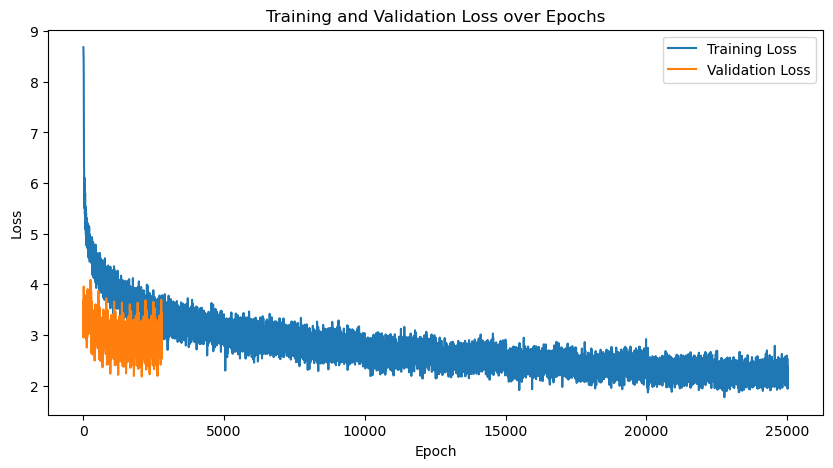

In [20]:
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
# train_losses, val_losses = train_model(
#     encoder, decoder, criterion, decoder_optimizer, train_loader, val_loader, num_epochs
# )

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 Caption generation and testing

In [16]:
def generate_caption(encoder, decoder, image, vocab, max_length=50):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.to(device)
        feature = encoder(image.unsqueeze(0))
        sampled_ids = decoder.sample(feature, max_length)
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<END>':
                break
            sampled_caption.append(word)
        sentence = []
        for c in sampled_caption:
            if len(sentence) == 0:
                sentence.append(c)
            elif sentence[-1] != c:
                sentence.append(c)
                
        try: sentence.remove('<END>')
        except: pass

        sentence = ' '.join(sentence)
    return sentence

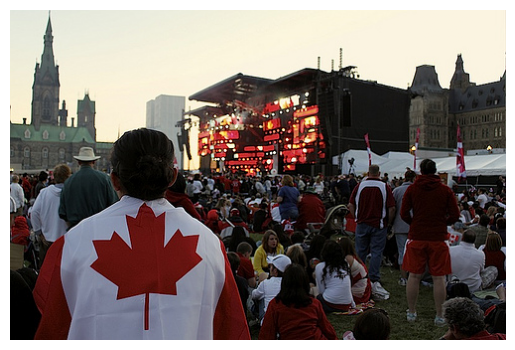

Caption idx 17495: trousers marching band <UNK> and the other is a <UNK> .


In [17]:
import random

# image picking
idx = random.randint(0, len(test_dataset))
test_image, _ = test_dataset[idx]
print_image, _ = test_dataset_or[idx]
plt.imshow(print_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# caption generation
caption = generate_caption(encoder, decoder, test_image, vocab)
print(f"Caption idx {idx}: {caption}")

## 4.1 Plot losses

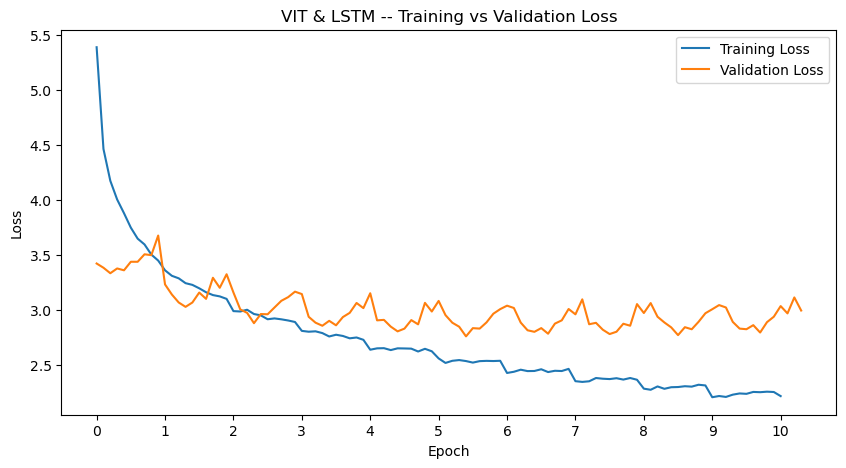

In [24]:
def mean(l): return sum(l)/len(l)

lt = len(train_losses)
lv = len(val_losses)
step = 100
t_l = [mean(train_losses[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
v_l = [mean(val_losses[i:min(i+lv//step, lv)]) for i in range(0, lv, lv//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.plot(v_l, label='Validation Loss')
plt.title('VIT & LSTM -- Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), 10), labels=range(0, 11))
plt.legend()
plt.show()
# plt.savefig('../img/vit_rnn.pdf', format='pdf')

# 5 Checkpoint

In [12]:
# save model
# torch.save(
#     {
#         "encoder_state_dict": encoder.state_dict(),
#         "decoder_state_dict": decoder.state_dict(),
#         "vocab": vocab,
#         "embedding_matrix": embedding_matrix,
#         "train_losses": train_losses,
#         "val_losses": val_losses,
#     },
#     "../ckpt/vit_rnn.ckpt",
# )

checkpoint = torch.load("../ckpt/vit_rnn.ckpt", map_location=torch.device('cpu'))
vocab = checkpoint["vocab"]
embedding_matrix = checkpoint["embedding_matrix"]

embed_size = 200
hidden_size = 512
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size).to(device)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder = encoder.to(device)

decoder = DecoderRNN(embed_size, hidden_size, vocab_size, embedding_matrix).to(device)
decoder.load_state_dict(checkpoint["decoder_state_dict"])
decoder = decoder.to(device)

train_losses = checkpoint["train_losses"]
val_losses = checkpoint["val_losses"]

# 6 Bleu and Rouge

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

smoothing_function = SmoothingFunction().method4

bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores = [], [], [], []

rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

captions_file = "../data/test/captions_test.txt"
captions_test_df = pd.read_table(captions_test_file, delimiter=',', header=None, names=['image', 'caption'])
captions_test_df.dropna(inplace=True)


for idx in range(len(test_dataset)):
	      
    # Get the ground truth captions (list of 5 captions) and the generated caption
	image, _ = test_dataset[idx]
	reference_captions = [captions_test_df.iloc[idx, 1]]
	generated_caption = generate_caption(encoder, decoder, image, vocab)
	# print(f"{reference_captions[0]} ### {generated_caption}")

    # Tokenize reference captions and generated caption
	reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
	generated_tokens = nltk.word_tokenize(generated_caption.lower())

    # Calculate BLEU score with multiple references
	bleu_score = sentence_bleu(
        reference_tokens, generated_tokens, smoothing_function=smoothing_function
    )
	bleu_scores.append(bleu_score)

    # Calculate ROUGE scores for each reference and keep the best match
	rouge_scores = [rouge.score(ref, generated_caption) for ref in reference_captions]
	best_rouge1 = np.mean([score["rouge1"].fmeasure for score in rouge_scores])
	best_rouge2 = np.mean([score["rouge2"].fmeasure for score in rouge_scores])
	best_rougeL = np.mean([score["rougeL"].fmeasure for score in rouge_scores])

	rouge1_scores.append(best_rouge1)
	rouge2_scores.append(best_rouge2)
	rougeL_scores.append(best_rougeL)
    
	if (idx + 1) % 100 == 0: print(f"Processed {idx+1}/{len(test_dataset)} images")

# Calculate average scores
avg_bleu_score = np.mean(bleu_scores)
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

# Print average scores
print(f"Average BLEU Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")

Processed 100/23839 images
Processed 200/23839 images
Processed 300/23839 images
Processed 400/23839 images
Processed 500/23839 images
Processed 600/23839 images
Processed 700/23839 images
Processed 800/23839 images
Processed 900/23839 images
Processed 1000/23839 images
Processed 1100/23839 images
Processed 1200/23839 images
Processed 1300/23839 images
Processed 1400/23839 images
Processed 1500/23839 images
Processed 1600/23839 images
Processed 1700/23839 images
Processed 1800/23839 images
Processed 1900/23839 images
Processed 2000/23839 images
Processed 2100/23839 images
Processed 2200/23839 images
Processed 2300/23839 images
Processed 2400/23839 images
Processed 2500/23839 images
Processed 2600/23839 images
Processed 2700/23839 images
Processed 2800/23839 images
Processed 2900/23839 images
Processed 3000/23839 images
Processed 3100/23839 images
Processed 3200/23839 images
Processed 3300/23839 images
Processed 3400/23839 images
Processed 3500/23839 images
Processed 3600/23839 images
P

In [19]:
torch.save(
    {
		"bleu_scores": bleu_scores,
		"rouge1_scores": rouge1_scores,
		"rouge2_scores": rouge2_scores,
		"rougeL_scores": rougeL_scores,
	},
	"../ckpt/scores_vit.ckpt",
)

# Load scores
ckpt = torch.load("../ckpt/scores_vit.ckpt")
bleu_scores = ckpt["bleu_scores"]
rouge1_scores = ckpt["rouge1_scores"]
rouge2_scores = ckpt["rouge2_scores"]
rougeL_scores = ckpt["rougeL_scores"]

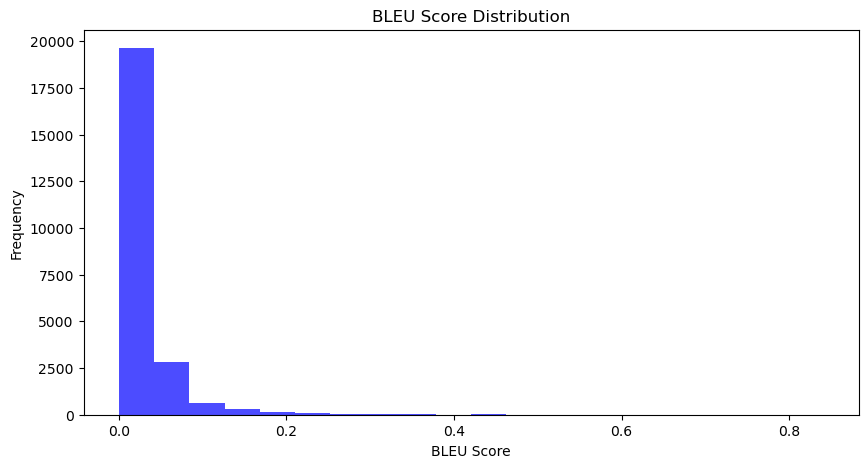

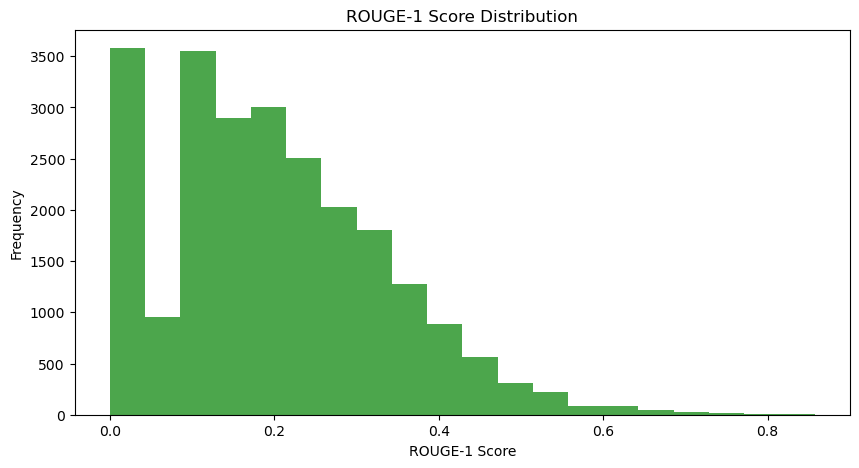

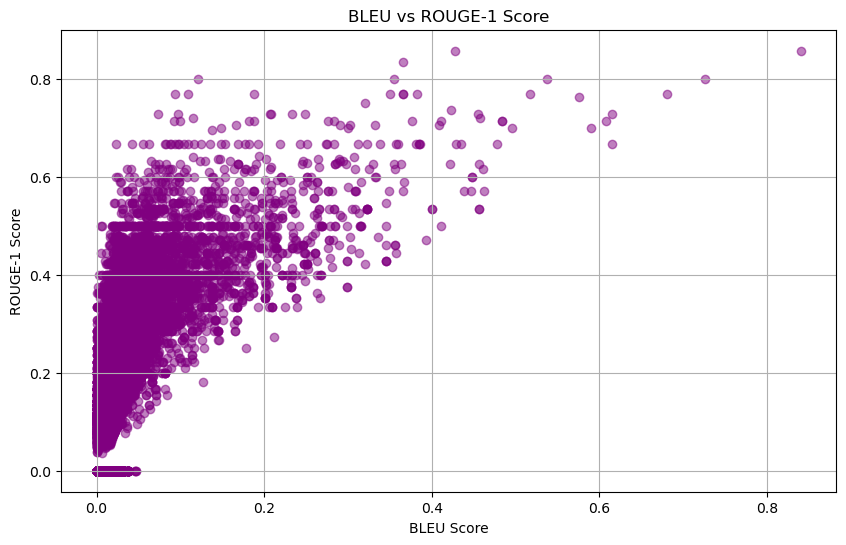

In [20]:
# Plot BLEU Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(bleu_scores, bins=20, color='blue', alpha=0.7)
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.show()

# Plot ROUGE-1 Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(rouge1_scores, bins=20, color='green', alpha=0.7)
plt.title('ROUGE-1 Score Distribution')
plt.xlabel('ROUGE-1 Score')
plt.ylabel('Frequency')
plt.show()

# Plot BLEU vs ROUGE-1 Score
plt.figure(figsize=(10, 6))
plt.scatter(bleu_scores, rouge1_scores, alpha=0.5, color='purple')
plt.title('BLEU vs ROUGE-1 Score')
plt.xlabel('BLEU Score')
plt.ylabel('ROUGE-1 Score')
plt.grid(True)
plt.show()
